# **Project Name**    - Air Quality (multiclassification/regresion/NN)
##### **Data**            - https://www.kaggle.com/datasets/rabieelkharoua/air-quality-and-health-impact-dataset/data

HealthImpactScore: A score indicating the overall health impact based on air quality and other related factors, ranging from 0 to 100.
HealthImpactClass: Classification of the health impact based on the health impact score:

0: 'Very High' (HealthImpactScore >= 80)

1: 'High' (60 <= HealthImpactScore < 80)

2: 'Moderate' (40 <= HealthImpactScore < 60)

3: 'Low' (20 <= HealthImpactScore < 40)

4: 'Very Low' (HealthImpactScore < 20)

#Imports

In [1]:
# Changing scikit-learn 1.6.0 due to it's issues with XGB

!pip uninstall scikit-learn
!pip install scikit-learn==1.5.0


Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Would remove:
    /usr/local/lib/python3.11/dist-packages/scikit_learn-1.6.1.dist-info/*
    /usr/local/lib/python3.11/dist-packages/scikit_learn.libs/libgomp-a34b3233.so.1.0.0
    /usr/local/lib/python3.11/dist-packages/sklearn/*
Proceed (Y/n)? y
  Successfully uninstalled scikit-learn-1.6.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 43.9 MB/s eta 0:00:00


In [2]:
!pip install catboost
from catboost import CatBoostClassifier
from catboost import CatBoostRegressor

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.3 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick import ClassBalance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedShuffleSplit, KFold, GridSearchCV, cross_val_score, RandomizedSearchCV, StratifiedKFold, train_test_split
import pickle

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

from time import time

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [4]:
import warnings

# Suppress specific FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning, message=".*'force_all_finite'.*")


#Data Load

In [5]:
# Data loading from GitHub repository
def load_data(file_path):
    """Load the dataset from a specified file path."""
    try:
        df = pd.read_csv(file_path, index_col=0)
        df = df.reset_index(drop=True)
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

In [ ]:
file_path = 'https://raw.githubusercontent.com/Zanyata/Air_Quality/refs/heads/main/data/air_quality_health_impact_data.csv'
df = load_data(file_path)

#Check classification correctness

HealthImpactClass: Classification of the health impact based on the health impact score:

0: 'Very High' (HealthImpactScore >= 80)

1: 'High' (60 <= HealthImpactScore < 80)

2: 'Moderate' (40 <= HealthImpactScore < 60)

3: 'Low' (20 <= HealthImpactScore < 40)

4: 'Very Low' (HealthImpactScore < 20)

In [ ]:
# Creating bins for comparison with existing labels
bins = [0, 20, 40, 60, 80, 100]
bin_labels = [4, 3, 2, 1, 0]
df["Bins"] = pd.cut(df["HealthImpactScore"], bins=bins, labels=bin_labels)
df["Bins"] = df["Bins"].astype('float64')

In [ ]:
print(df.shape, df[df['HealthImpactClass']==df['Bins']].shape)

(5811, 15) (5580, 15)


We see that 231 (~4%) cases are wrongly categorized and should be fixed.

In [6]:
# Function for further usage - proper labels

def classification_correction(df):
  bins = [0, 20, 40, 60, 80, 100]
  bin_labels = [4, 3, 2, 1, 0]
  df["HealthImpactClass"] = pd.cut(df["HealthImpactScore"], bins=bins, labels=bin_labels)
  df["HealthImpactClass"] = df["HealthImpactClass"].astype('float64')
  return df

In [ ]:
df = classification_correction(df)

#Classification
Classificaton using HealthImpactClass

##EDA

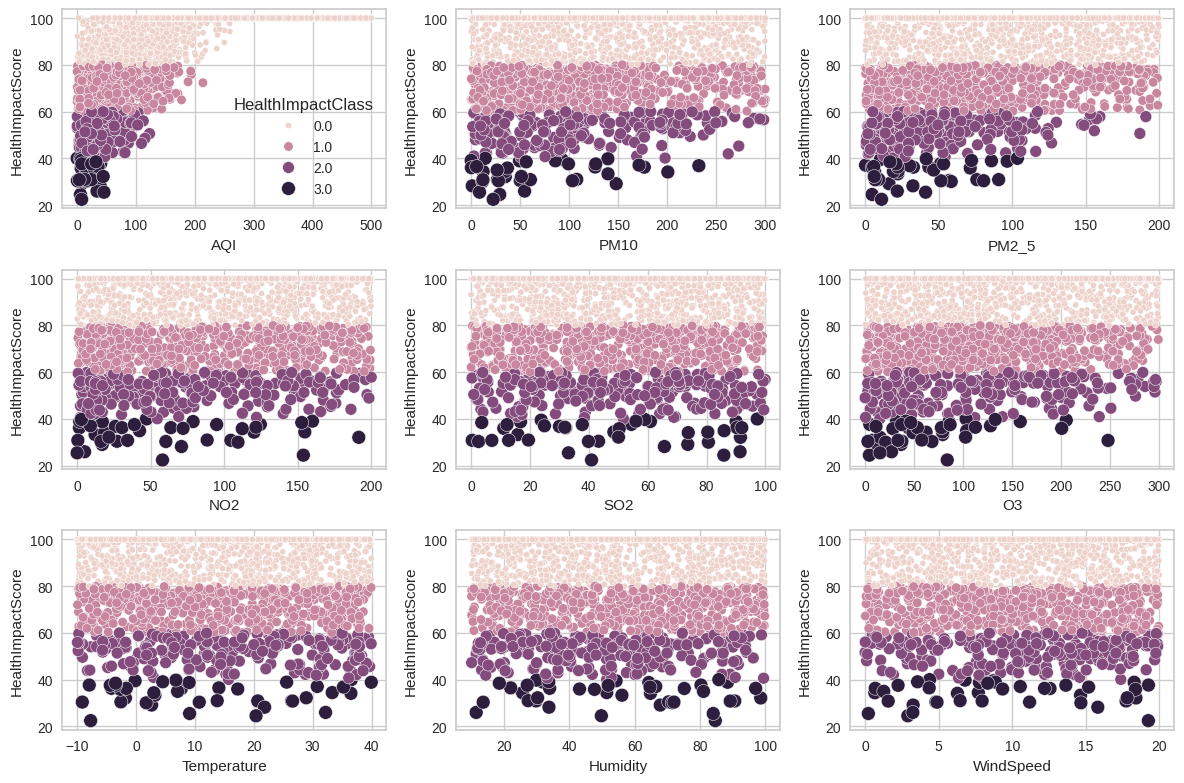

In [ ]:
target = "HealthImpactScore"
predictors = ['AQI', 'PM10', 'PM2_5', 'NO2', 'SO2', 'O3', 'Temperature', 'Humidity', 'WindSpeed']
plt.figure(figsize=(12,8))
for i, var in enumerate(df[predictors]):
  plt.subplot(3,3,i+1)
  sns.scatterplot(data=df, x=var, y=target, hue="HealthImpactClass", size="HealthImpactClass", sizes=(20, 100), legend=i == 0)
plt.tight_layout()
plt.show()

Health impact increases with increasing air polution. Atmospherical conditions (temperature, humidity, wind speed) doesn't seem to have a correlation with HealthImpactScore or Class.

In [ ]:
df = df.drop(columns="HealthImpactScore")

In [ ]:
df.shape

(5811, 13)

In [ ]:
df.head(5)

,AQI,PM10,PM2_5,NO2,SO2,O3,Temperature,Humidity,WindSpeed,RespiratoryCases,CardiovascularCases,HospitalAdmissions,HealthImpactClass
0,187.270059,295.853039,13.038560,6.639263,66.161150,54.624280,5.150335,84.424344,6.137755,7,5,1,0.0
1,475.357153,246.254703,9.984497,16.318326,90.499523,169.621728,1.543378,46.851415,4.521422,10,2,0,0.0
2,365.996971,84.443191,23.111340,96.317811,17.875850,9.006794,1.169483,17.806977,11.157384,13,3,0,0.0
3,299.329242,21.020609,14.273403,81.234403,48.323616,93.161033,21.925276,99.473373,15.302500,8,8,1,0.0
4,78.009320,16.987667,152.111623,121.235461,90.866167,241.795138,9.217517,24.906837,14.534733,9,0,1,0.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5811 entries, 0 to 5810
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   AQI                  5811 non-null   float64
 1   PM10                 5811 non-null   float64
 2   PM2_5                5811 non-null   float64
 3   NO2                  5811 non-null   float64
 4   SO2                  5811 non-null   float64
 5   O3                   5811 non-null   float64
 6   Temperature          5811 non-null   float64
 7   Humidity             5811 non-null   float64
 8   WindSpeed            5811 non-null   float64
 9   RespiratoryCases     5811 non-null   int64  
 10  CardiovascularCases  5811 non-null   int64  
 11  HospitalAdmissions   5811 non-null   int64  
 12  HealthImpactClass    5811 non-null   float64
dtypes: float64(10), int64(3)
memory usage: 590.3 KB


In [ ]:
df.duplicated().value_counts()

,count
False,5811


No duplicates, no null, only numerical values

In [ ]:
df.describe()

,AQI,PM10,PM2_5,NO2,SO2,O3,Temperature,Humidity,WindSpeed,RespiratoryCases,CardiovascularCases,HospitalAdmissions,HealthImpactClass
count,5811.000000,5811.000000,5811.000000,5811.000000,5811.000000,5811.000000,5811.000000,5811.000000,5811.000000,5811.000000,5811.000000,5811.000000,5811.000000
mean,248.438476,148.654997,100.223714,102.293445,49.456838,149.312431,14.975500,54.776853,9.989177,9.974187,4.988986,2.001033,0.191189
std,144.777638,85.698500,58.096612,57.713175,28.530329,86.534240,14.483067,26.020786,5.776950,3.129234,2.216791,1.398794,0.521250
min,0.005817,0.015848,0.031549,0.009625,0.011023,0.001661,-9.990998,10.001506,0.002094,1.000000,0.000000,0.000000,0.000000
25%,122.951293,75.374954,49.435171,53.538538,24.887264,73.999665,2.481500,31.995262,4.952343,8.000000,3.000000,1.000000,0.000000
50%,249.127841,147.634997,100.506337,102.987736,49.530165,149.559871,14.942428,54.543904,10.051742,10.000000,5.000000,2.000000,0.000000
75%,373.630668,222.436759,151.340260,151.658516,73.346617,223.380126,27.465374,77.641639,14.971840,12.000000,6.000000,3.000000,0.000000
max,499.858837,299.901962,199.984965,199.980195,99.969561,299.936812,39.963434,99.997493,19.999139,23.000000,14.000000,12.000000,3.000000


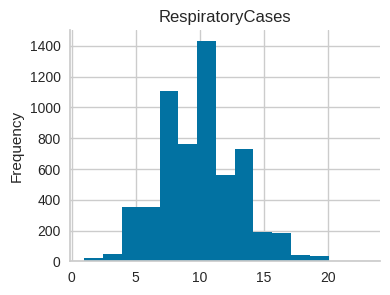

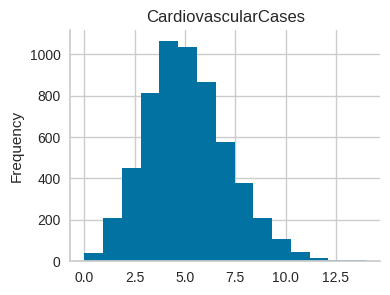

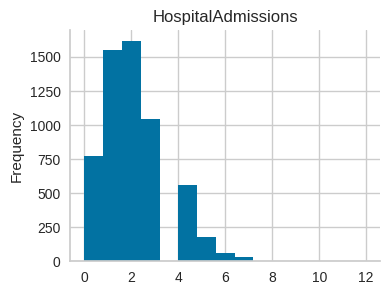

In [ ]:
i = ['RespiratoryCases', 'CardiovascularCases','HospitalAdmissions']

for i in df[i]:
  plt.figure(figsize=(4,3))
  df[i].plot(kind='hist', bins=15, title=i)
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.show()

RespiratoryCases and CardiovascularCases have normal distribution, HospitalAdmissions are right-skewed.

In [ ]:
for column in df:
  if len(df[column].value_counts()) < 3:
    print(df[column].value_counts())

No binary features

<Axes: >

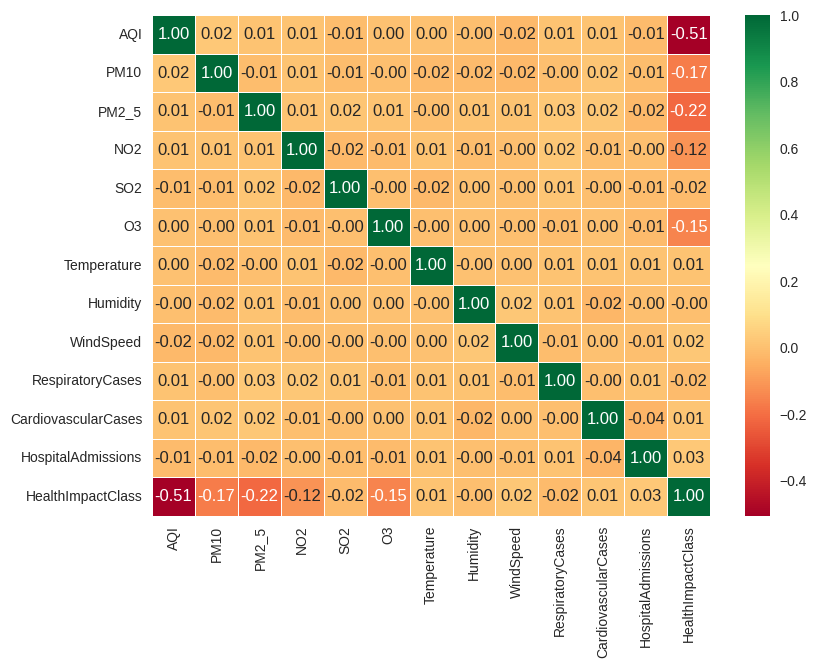

In [ ]:
# Correlation Heatmap
plt.figure(figsize=(9,6.5))
sns.heatmap(df.corr(),annot=True,linewidths=0.5,fmt='.2f',cmap="RdYlGn")

We can observe based on a correlation heatmap a negative correlation between dependent variable (HealthImpactClass) and AQI. Moderate negative correlation to PM10, PM2_5 and O3. The rest of features shows weak correlation to dependent variable. There isn't visible high multicollinearity between features that could negatively impact models performance.


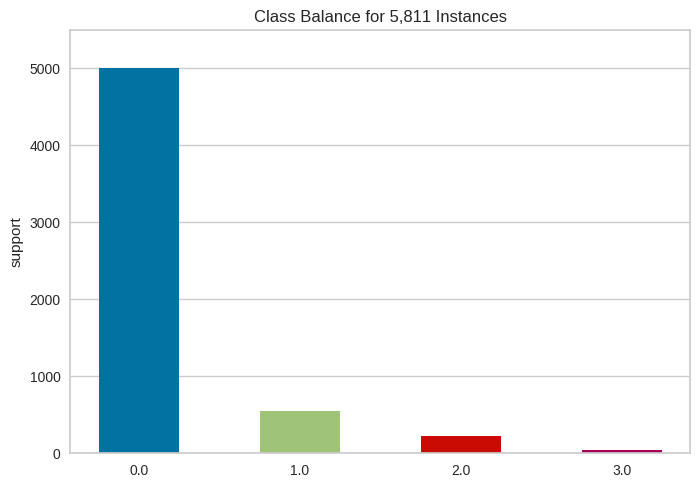

<Axes: title={'center': 'Class Balance for 5,811 Instances'}, ylabel='support'>

In [ ]:
# Visualization of class distribution
visualizer = ClassBalance()
visualizer.fit(df['HealthImpactClass'])
visualizer.show()

Imbalanced dataset, this needs to be taken in to concideration while preparing train and test splits.

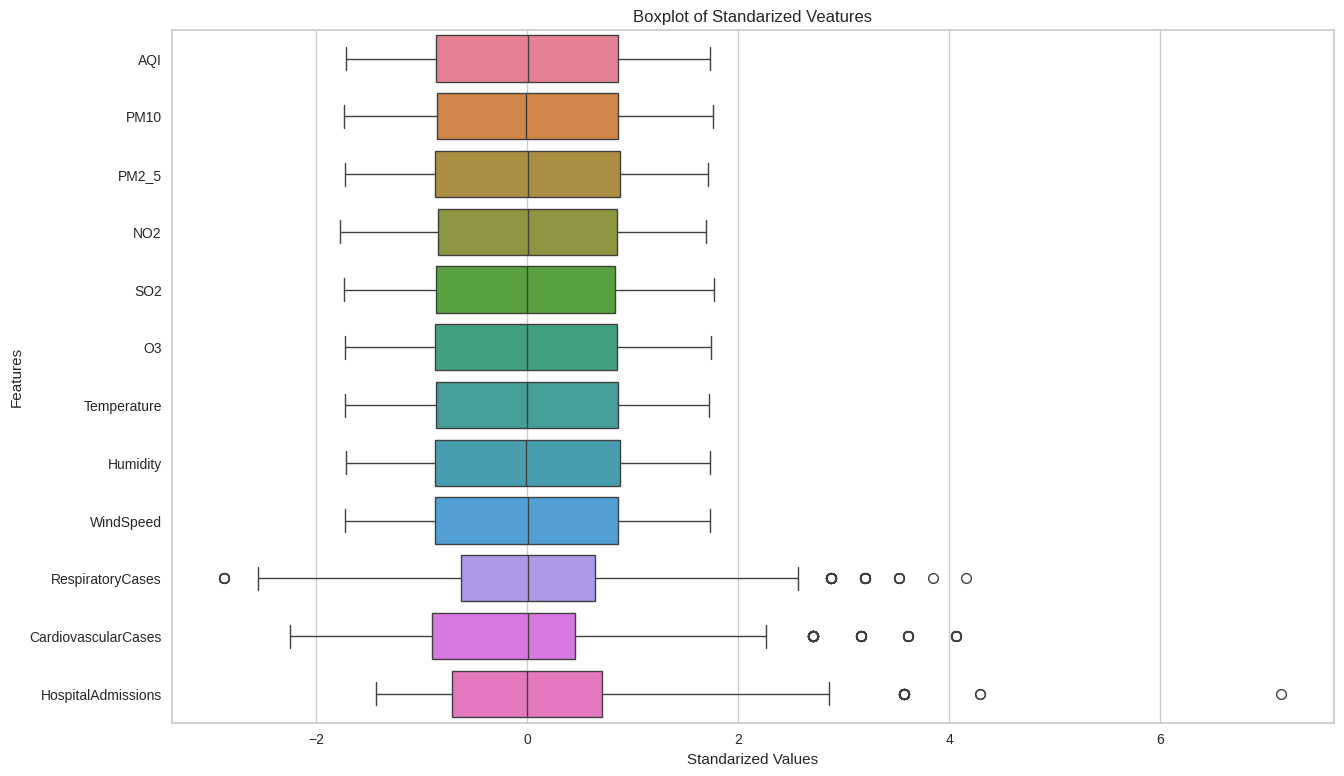

In [ ]:
# Outliers visualization
sc = StandardScaler()
labels=df.drop(columns="HealthImpactClass").columns
df_sc = sc.fit_transform(df.iloc[:, :-1])
plt.figure(figsize=(15,9))
sns.boxplot(data=df_sc, orient="h")
plt.yticks(ticks=range(len(labels)), labels=labels)
plt.xlabel("Standarized Values")
plt.ylabel("Features")
plt.title("Boxplot of Standarized Veatures")
plt.show()

There are some outliers. This data might be vital for ML interpretation so it shouldn't be removed on this preliminaty stage.

##Splitting

In [21]:
# Splitting data in to train and test sets, based on HelthImpactClass due to high impalance
def stratify_splitting(df):
  split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
  try:
    for train_index, test_index in split.split(df, df["HealthImpactClass"]):
      strat_train_set = df.loc[train_index]
      strat_test_set = df.loc[test_index]
    feature_names = strat_train_set.drop(columns=["HealthImpactScore", "HealthImpactClass"]).columns
    return strat_train_set, strat_test_set, feature_names
  except Exception as e:
    print(f"Error while splitting: {e}")
    return None

# Splitting to X and y NumPy arrays
def xy_splitting_scaling(strat_train_set, strat_test_set):
  try:
    X_train = strat_train_set.drop(columns=["HealthImpactScore", "HealthImpactClass"])
    y_train = strat_train_set["HealthImpactClass"].values # Convert to NumPy array
    X_test = strat_test_set.drop(columns=["HealthImpactScore", "HealthImpactClass"])
    y_test = strat_test_set["HealthImpactClass"].values
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    return X_train, y_train, X_test, y_test
  except Exception as e:
    print(f"Error while xy_splitting: {e}")

In [22]:
# Dataset with corrected classes
file_path = 'https://raw.githubusercontent.com/Zanyata/Air_Quality/refs/heads/main/data/air_quality_health_impact_data.csv'
df = load_data(file_path)
df = classification_correction(df)
strat_train_set, strat_test_set, feature_names = stratify_splitting(df)
X_train, y_train, X_test, y_test = xy_splitting_scaling(strat_train_set, strat_test_set)

In [ ]:
# Raw dataset without correcting classes - for ML performance checking
file_path = 'https://raw.githubusercontent.com/Zanyata/Air_Quality/refs/heads/main/data/air_quality_health_impact_data.csv'
df_raw = load_data(file_path)
strat_train_set_raw, strat_test_set_raw, feature_names = stratify_splitting(df_raw)
X_train_raw, y_train_raw, X_test_raw, y_test_raw = xy_splitting_scaling(strat_train_set_raw, strat_test_set_raw)

##ML

###Manual MultiML

Since it is a smaller dataset, the performance of all standart models can be checked.

In [ ]:
# Define models with appropriate class weight handling
models = {
    "log": LogisticRegression(solver="lbfgs", class_weight="balanced"),
    "raf": RandomForestClassifier(class_weight="balanced"),
    "svc": SVC(probability=True, class_weight="balanced"),
    "cat": CatBoostClassifier(verbose=0, auto_class_weights="Balanced"),
    "lgbm": LGBMClassifier(class_weight="balanced"),
    "xgb": XGBClassifier(),  #XGBoost does not have a direct parameter like scale_pos_weight for multi-class problems.
}


In [ ]:
metrics = [precision_score, recall_score, f1_score]

def evaluate_model(models, X_train, y_train, X_test, y_test):
    scores = []

    """Evaluate the model's performance on train and test sets."""
    sample_weights = compute_sample_weight(class_weight="balanced", y=y_test)
    plt.figure(figsize=(10,6))

    for i, (name, model) in enumerate(models.items()):
      # Train model
      model.fit(X_train, y_train)

      # Predictions
      preds = model.predict(X_test)
      preds_proba = None

      if hasattr(model, "predict_proba"):  # Check if predict_proba is available
          preds_proba = model.predict_proba(X_test)

      model_scores = {"Model": name}
      for metric in metrics:
         model_scores[metric.__name__] = metric(y_test, preds, sample_weight=sample_weights, average='weighted', zero_division=0)
         # zero_division=0 parameter when calculating metrics (precision_score, recall_score, f1_score) to handle these cases.
         # This will replace undefined precision values with 0.0 instead of raising a warning.
      model_scores["accuracy"] = accuracy_score(y_test, preds, sample_weight=sample_weights)

      # Compute ROC-AUC for models with probabilities
      if preds_proba is not None:
          model_scores["roc_auc"] = roc_auc_score(
              y_test, preds_proba, sample_weight=sample_weights, multi_class="ovr", average="weighted"
          )
      scores.append(model_scores)

      # Confusion Matrix plot
      conf_matrix = confusion_matrix(y_test, preds, sample_weight=sample_weights)
      plt.subplot(2, 3, i + 1)
      sns.heatmap(conf_matrix,
                  annot=True,
                  fmt=".0f",
                  xticklabels=np.unique(y_test),
                  yticklabels=np.unique(y_test))
      plt.xlabel('Predicted Label')
      plt.ylabel('True Label')
      plt.title(f'Confusion Matrix {name}')
    plt.tight_layout()
    plt.show()

    results_df = pd.DataFrame(scores)

    print(results_df.to_string(index=False))


Initial dataset (raw) analysis, without labels correction:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:37:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


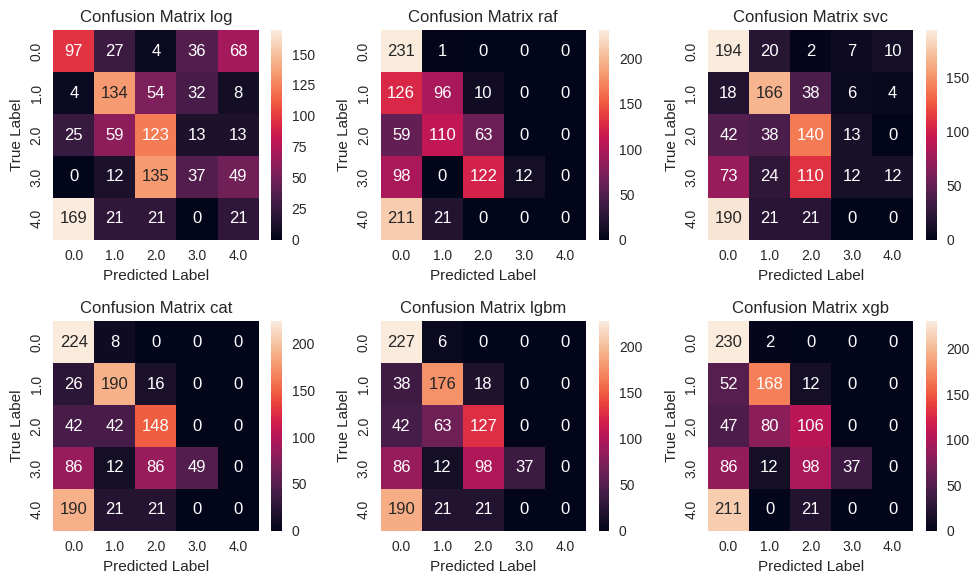

Model  precision_score  recall_score  f1_score  accuracy  roc_auc
  log         0.333320      0.354101  0.333535  0.354101 0.698215
  raf         0.412573      0.346583  0.259105  0.346583 0.719195
  svc         0.352767      0.440158  0.356515  0.440158 0.635599
  cat         0.525969      0.525687  0.449232  0.525687 0.727749
 lgbm         0.500508      0.487612  0.406034  0.487612 0.721405
  xgb         0.490860      0.465445  0.387841  0.465445 0.684187


In [ ]:
evaluate_model(models, X_train_raw, y_train_raw, X_test_raw, y_test_raw)

Dataset analysis after labels correction:

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:02:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


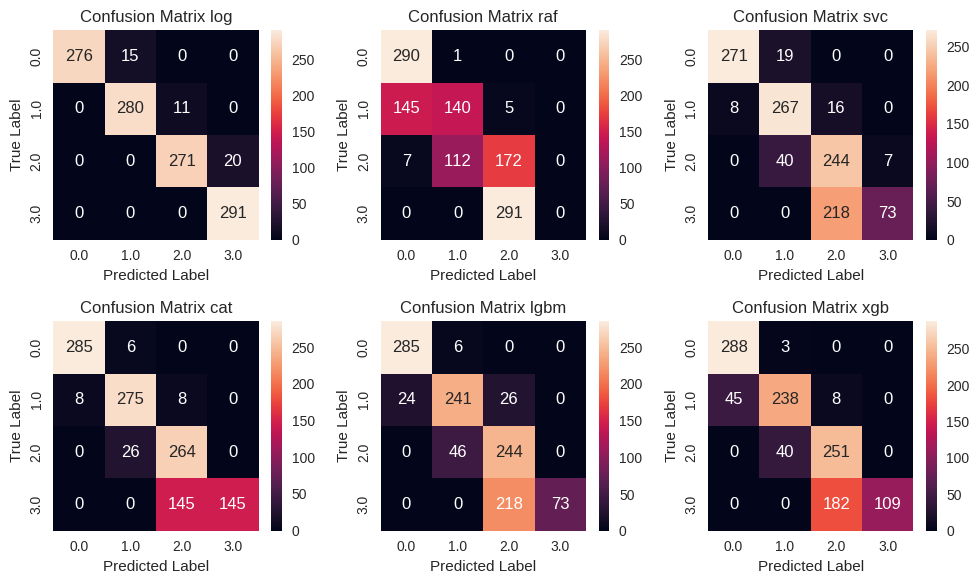

Model  precision_score  recall_score  f1_score  accuracy  roc_auc
  log         0.961865      0.960877  0.960859  0.960877 0.996687
  raf         0.394084      0.517433  0.439827  0.517433 0.886511
  svc         0.804510      0.735539  0.711536  0.735539 0.947814
  cat         0.875215      0.833641  0.827236  0.833641 0.969806
 lgbm         0.811473      0.724800  0.700831  0.724800 0.940309
  xgb         0.820738      0.761707  0.747056  0.761707 0.930306


In [ ]:
evaluate_model(models, X_train, y_train, X_test, y_test)

Corrected dataset shows very high linear separablility, meaning simple linear decision boundaries work well.
Some models (Random Forest, SVC) perform worse, indicating possible influence of class imbalance.
The best models are Logistic Regression, CatBoost Classifier and XGB Classifier.

This shows clearly how much of noise those 231 (~4%) wrongly categorized samples contribute. For highly noised data as dataset analysis without correcting classification shows, CatBoost Classifier and LGBM Classifier would be a good choice.

###Hyperparameters tuning after classification correction
Logistic Regression, CatBoost Classifier, XGBoost Classifier

In [9]:
# Define metrics to evaluate
metrics = [precision_score, recall_score, f1_score]

# Evaluation function
def evaluate(preds, preds_proba, metrics, y_test):
  # Sample_weight adjusts for class imbalance, while average="weighted" ensures a proportionally balanced contribution to the metric.
    scores = []
    sample_weights = compute_sample_weight(class_weight="balanced", y=y_test)
    for metric in metrics:
        scores.append(metric(y_test, preds, sample_weight=sample_weights, average='weighted', zero_division=0))

    # Compute ROC-AUC score
    accuracy = accuracy_score(y_test, preds, sample_weight=sample_weights)
    scores.append(accuracy)
    roc_auc = roc_auc_score(y_test, preds_proba, sample_weight=sample_weights, multi_class="ovr", average="weighted")
    scores.append(roc_auc)

    # Print classification report
    print("\n=== Classification Report ===")
    print(classification_report(y_test, preds))

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, preds, sample_weight=sample_weights)
    return scores, conf_matrix

# Function to plot evaluation results
def plot_evaluation(scores, conf_matrix):
    print("\n=== Evaluation Metrics ===")
    print('Precision: '+str(scores[1]))
    print('Recall: '+str(scores[2]))
    print('F1 Score: '+str(scores[3]))
    print('Accuracy: '+str(scores[0]))
    print('ROC-AUC Score: '+str(scores[4]))

    # Plot confusion matrix with heatmap
    sns.heatmap(conf_matrix,
                  annot=True,
                  fmt=".0f",
                  xticklabels=np.unique(y_test),
                  yticklabels=np.unique(y_test))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix')
    plt.show()


In [10]:
# Model training using randomized grid search for training speed-up
def model_tuning(model, param_grid, model_name, nIter):

  folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

  # RandomizedSearchCV
  GS = RandomizedSearchCV(
      estimator=model,
      param_distributions=param_grid,
      n_iter=nIter,
      scoring= 'f1_weighted',
      cv=folds,
      return_train_score=True,
      verbose=0,
      n_jobs=-1,  # Use all CPUs
      refit=True,
      random_state=42
  )

  # Model taining and computing predictions
  GS.fit(X_train, y_train)
  best_model = GS.best_estimator_
  best_params = GS.best_params_
  preds_train= GS.predict(X_train)
  preds_test = GS.predict(X_test)
  preds_proba_test = GS.predict_proba(X_test)

  sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)

  train_precision = precision_score(y_train, preds_train, sample_weight=sample_weights, average="weighted", zero_division=0)
  train_recall = recall_score(y_train, preds_train, sample_weight=sample_weights, average="weighted", zero_division=0)
  train_f1 = f1_score(y_train, preds_train, sample_weight=sample_weights, average="weighted", zero_division=0)
  train_accuracy = accuracy_score(y_train, preds_train, sample_weight=sample_weights)

  print("=== Training Metrics ===")
  print(f"Train Precision: {train_precision:.4f}")
  print(f"Train Recall: {train_recall:.4f}")
  print(f"Train F1 Score: {train_f1:.4f}")
  print(f"Train Accuracy: {train_accuracy:.4f}")

  # Saving the best model
  filename = f"{model_name}.sav"
  pickle.dump(best_model, open(filename, "wb"))
  print(f"Best Parameters: {best_params}")
  return best_model, preds_test, preds_proba_test

###Logistic Regression

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
2080 fits failed out of a total of 5000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
350 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py", line 1194, in fit
    solver = _check_s

=== Training Metrics ===
Train Precision: 1.0000
Train Recall: 1.0000
Train F1 Score: 1.0000
Train Accuracy: 1.0000
Best Parameters: {'solver': 'lbfgs', 'random_state': 42, 'penalty': None, 'max_iter': 100, 'class_weight': None, 'C': 0.0001}

=== Classification Report ===
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1001
         1.0       1.00      0.98      0.99       110
         2.0       0.98      0.98      0.98        44
         3.0       0.89      1.00      0.94         8

    accuracy                           1.00      1163
   macro avg       0.97      0.99      0.98      1163
weighted avg       1.00      1.00      1.00      1163


=== Evaluation Metrics ===
Precision: 0.9897727272727274
Recall: 0.9897616348758078
F1 Score: 0.9897727272727274
Accuracy: 0.9898880447267543
ROC-AUC Score: 0.9999311294765839


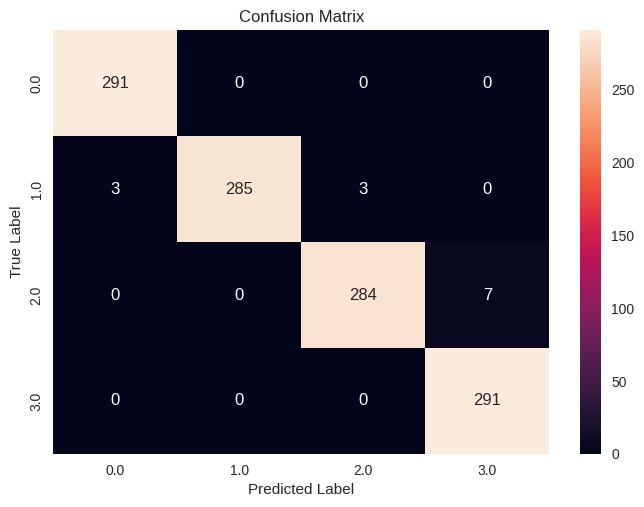

In [19]:
# Model instantiation
model = LogisticRegression()

model_name = "class_Log"

# Parameter Grid
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', None],  # Regularization type
    'C': np.logspace(-4, 4, 10),  # Regularization strength (inverse of lambda)
    'solver': ['liblinear', 'lbfgs', 'saga'],  # Optimization algorithm
    'max_iter': [100, 200, 500],  # Maximum iterations for convergence
    'class_weight': [None, 'balanced'],
    'random_state': [42],  # Fixed for reproducibility
}

nIter = 500 # Number of parameter settings to be sampled by RandomizedSearchCV

Log, preds_Log, preds_proba_Log  = model_tuning(model, param_grid, model_name, nIter)

scores_Log, conf_matrix_Log = evaluate(preds_Log, preds_proba_Log, metrics, y_test)
plot_evaluation(scores_Log, conf_matrix_Log)

After hyperparameters tuning Logistic Regression metrics: presicion, recall, f1_score and accuracy improved. Slight underfitting.

###XGB

=== Training Metrics ===
Train Precision: 0.9243
Train Recall: 0.9107
Train F1 Score: 0.9095
Train Accuracy: 0.9107
Best Parameters: {'subsample': 1, 'reg_lambda': 0, 'reg_alpha': 0.05, 'n_estimators': 200, 'min_child_weight': 8, 'max_depth': 1, 'learning_rate': 1, 'gamma': 0.3, 'colsample_bytree': 1}
Search took 4926.15 seconds.

=== Classification Report ===
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      1001
         1.0       0.88      0.89      0.88       110
         2.0       0.83      0.77      0.80        44
         3.0       0.50      0.12      0.20         8

    accuracy                           0.97      1163
   macro avg       0.80      0.70      0.72      1163
weighted avg       0.97      0.97      0.97      1163


=== Evaluation Metrics ===
Precision: 0.6959103396603411
Recall: 0.6488987871012715
F1 Score: 0.6959103396603398
Accuracy: 0.7564750522799804
ROC-AUC Score: 0.9159753598674065


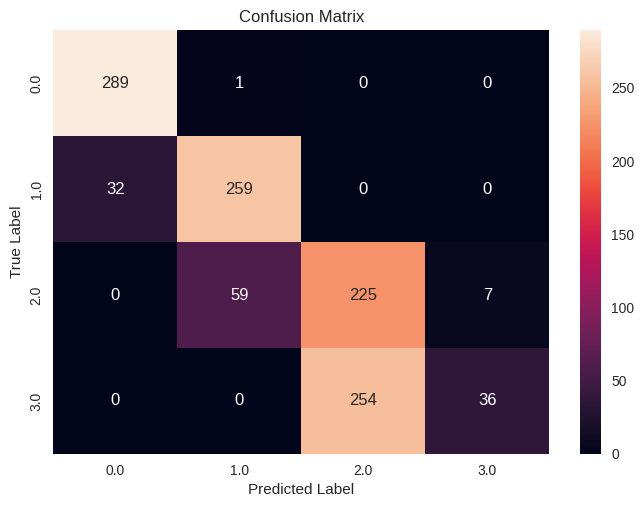

In [12]:
# Model instantiation
# Logical Parameters choosed for fastest logic
model = XGBClassifier(tree_method= 'hist', objective= 'multi:softmax', eval_metric= 'merror', booster= 'gbtree', seed=42)

model_name = "class_XGB"

# Time count
start = time()

# Parameter Grid for RandomizedSearchCV
param_grid = {
    # Model complexity
    'n_estimators': [200, 300],  #  tree count, low to prevent overfitting
    'max_depth': [1, 3, 6, 9],  # maximum deph of trees
    'learning_rate': [0.01, 0.2, 0.5, 0.7, 1, 1.3],
    # Variability (Randomness)
    'subsample': [0.4, 0.6, 0.8, 1],  # how many training samples (rows) are used in each boosting round
    'colsample_bytree': [0.4, 0.6, 0.8, 1],  # how many features (columns) are randomly chosen per tree
    # Regularization
    'min_child_weight': [4, 8, 12, 16],  # minimum number of samples (instances) required in a leaf node before a split is allowed, Higher values increase regularization, meaning fewer splits (simpler trees)
    'gamma': [0.3, 0.6, 0.8, 1],  # how much the loss function must improve before making a split.
    'reg_lambda': [0, 1, 3, 5, 7, 9, 12],  # L2 regularization (Ridge-like penalty)
    'reg_alpha': [0, 0.05, 0.1, 0.5, 1, 3, 5],  # L1 regularization

}

nIter = 1000 # Number of parameter settings to be sampled by RandomizedSearchCV

XGB, preds_XGB, preds_proba_XGB = model_tuning(model, param_grid, model_name, nIter)
print(
    "Search took %.2f seconds."
    % ((time() - start))
)
scores_XGB, conf_matrix_XGB = evaluate(preds_XGB, preds_proba_XGB, metrics, y_test)
plot_evaluation(scores_XGB, conf_matrix_XGB)

Despite many attempts, hyperparameters tuning wasn't succesful. XGB is highly overfitted.

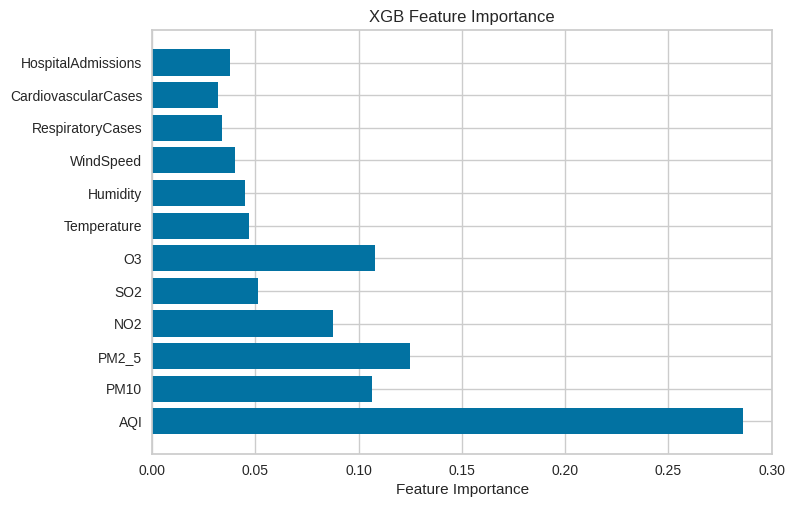

In [ ]:
# Feature importances
feature_importance = XGB.feature_importances_
plt.barh(range(len(feature_importance)), feature_importance)
plt.yticks(range(len(feature_importance)), feature_names)
plt.xlabel("Feature Importance")
plt.title("XGB Feature Importance")
plt.show()


The 4 most importans features are:

AQI: Air Quality Index, a measure of how polluted the air currently is or how polluted it is forecast to become.

PM10: Concentration of particulate matter less than 10 micrometers in diameter (μg/m³).

PM2_5: Concentration of particulate matter less than 2.5 micrometers in diameter (μg/m³).

O3: Concentration of ozone (ppb).

###CatBoost

*Early stopping is an important technique in both classification and regression tasks when using CatBoost and LightGBM, as it helps prevent overfitting by stopping training when the model's performance on a validation set stops improving*

=== Training Metrics ===
Train Precision: 1.0000
Train Recall: 1.0000
Train F1 Score: 1.0000
Train Accuracy: 1.0000
Best Parameters: {'learning_rate': 0.3, 'l2_leaf_reg': 0.1, 'iterations': 1000, 'depth': 3}
Search took 2411.76 seconds.

=== Classification Report ===
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      1001
         1.0       0.86      0.93      0.89       110
         2.0       0.87      0.93      0.90        44
         3.0       0.83      0.62      0.71         8

    accuracy                           0.98      1163
   macro avg       0.89      0.87      0.87      1163
weighted avg       0.98      0.98      0.98      1163


=== Evaluation Metrics ===
Precision: 0.867276473526474
Recall: 0.865075357970378
F1 Score: 0.8672764735264735
Accuracy: 0.8895192696850336
ROC-AUC Score: 0.9823167362940092


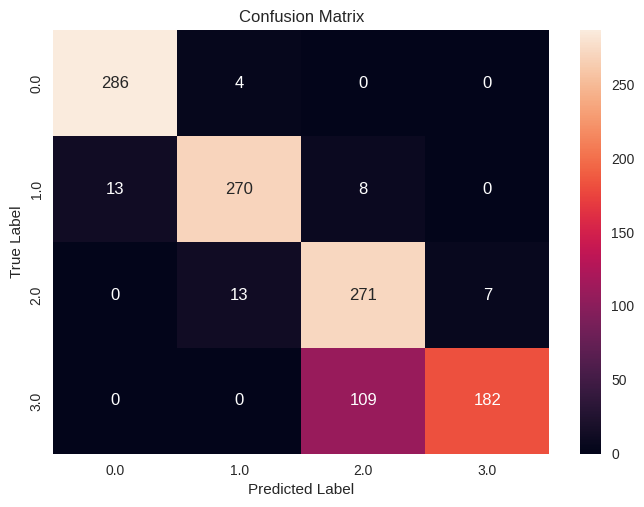

In [20]:
# Model instantiation - model with maximized test metrics
model = CatBoostClassifier(verbose=0, random_state=42, early_stopping_rounds=50, auto_class_weights='Balanced')

model_name = "class_CatBoost"

# Time counter
start = time()

# Parameter Grid
param_grid = {
    'iterations': [1000],  # Number of boosting iterations (trees)
    'learning_rate': [0.3, 0.4, 0.5],  # Step size shrinkage for weight updates
    'depth': [1, 3, 6],  # Depth of each tree
    'l2_leaf_reg': [0.1, 0.5, 0.8],  # L2 regularization coefficient
}

nIter = 27 # Number of parameter settings to be sampled by RandomizedSearchCV

best_CatBoost, preds_CatBoost, preds_proba_CatBoost  = model_tuning(model, param_grid, model_name, nIter)
print(
    "Search took %.2f seconds."
    % ((time() - start))
)

scores_CatBoost, conf_matrix_CatBoost = evaluate(preds_CatBoost, preds_proba_CatBoost, metrics, y_test)
plot_evaluation(scores_CatBoost, conf_matrix_CatBoost)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 72 is smaller than n_iter=100. Running 72 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


=== Training Metrics ===
Train Precision: 0.9938
Train Recall: 0.9936
Train F1 Score: 0.9936
Train Accuracy: 0.9936
Best Parameters: {'rsm': 0.4, 'loss_function': 'MultiClass', 'learning_rate': 0.15, 'l2_leaf_reg': 2, 'iterations': 500, 'depth': 3}
Search took 1136.48 seconds.

=== Classification Report ===
              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98      1001
         1.0       0.71      0.92      0.80       110
         2.0       0.75      0.91      0.82        44
         3.0       1.00      0.38      0.55         8

    accuracy                           0.95      1163
   macro avg       0.87      0.79      0.79      1163
weighted avg       0.96      0.95      0.95      1163


=== Evaluation Metrics ===
Precision: 0.7913274225774232
Recall: 0.7792721416741532
F1 Score: 0.7913274225774226
Accuracy: 0.8585442305485028
ROC-AUC Score: 0.9647046135682502


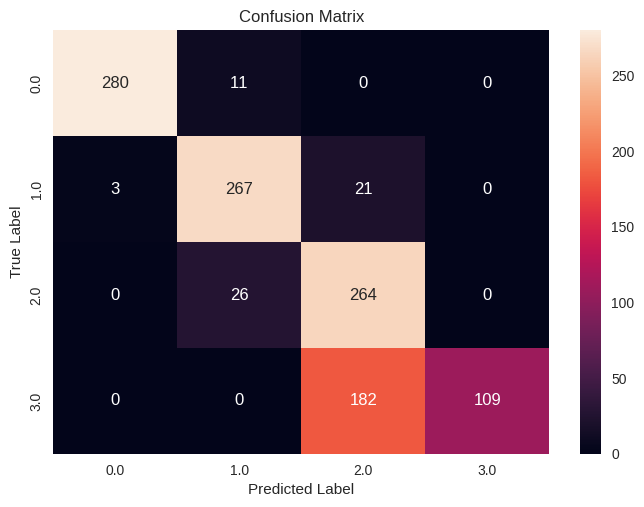

In [13]:
# Model instantiation - model with attempting to prevent overfitting
model = CatBoostClassifier(bootstrap_type='Bayesian', verbose=0, random_state=42, early_stopping_rounds=30, auto_class_weights='Balanced')

model_name = "class_CatBoost3"

# Time counter
start = time()

# Parameter Grid
param_grid = {
    'iterations': [400, 500],  # Reduce to avoid excessive fitting
    'learning_rate': [0.05, 0.1, 0.15],  # Slightly lower for stability
    'depth': [2, 3],  # Lower depth to prevent overfitting
    'l2_leaf_reg': [2, 3, 5],  # Stronger regularization
    'rsm': [0.4, 0.5],  # Lower feature subsampling
    'loss_function': ['MultiClass'],  # Alternative for class imbalance
}



nIter = 100 # Number of parameter settings to be sampled by RandomizedSearchCV

best_CatBoost, preds_CatBoost, preds_proba_CatBoost  = model_tuning(model, param_grid, model_name, nIter)
print(
    "Search took %.2f seconds."
    % ((time() - start))
)

scores_CatBoost, conf_matrix_CatBoost = evaluate(preds_CatBoost, preds_proba_CatBoost, metrics, y_test)
plot_evaluation(scores_CatBoost, conf_matrix_CatBoost)

CatBoost is highly overfitted.

ML Classification Conclusion

In classification for this particular dataset Logistic Regression, CatBoost Classifier and XGB Classifier had the best outcomes.

Even Logistic Regression has the best metrics scores, it is advisable to use more complex models.

Hyperparameter tuning for Catboost and XGB with good metrics and prevention of overfitting is hard to obtain.  

#Regression
Regression using HealthImpactScore

##EDA

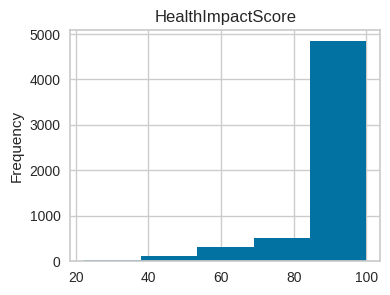

In [ ]:
# Histogram of HealthImpactScore
plt.figure(figsize=(4,3))
df['HealthImpactScore'].plot(kind='hist', bins=5, title="HealthImpactScore")
plt.show()

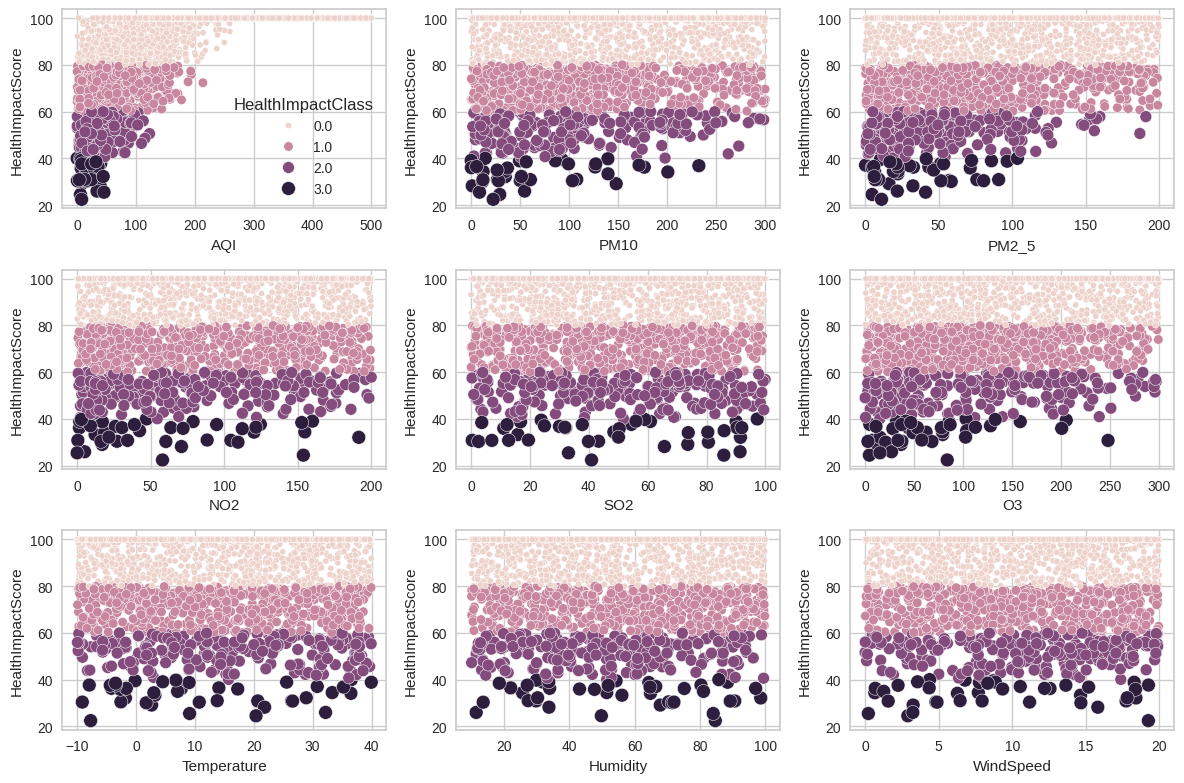

In [ ]:
target = "HealthImpactScore"
predictors = ['AQI', 'PM10', 'PM2_5', 'NO2', 'SO2', 'O3', 'Temperature', 'Humidity', 'WindSpeed']
plt.figure(figsize=(12,8))
for i, var in enumerate(df[predictors]):
  plt.subplot(3,3,i+1)
  sns.scatterplot(data=df, x=var, y=target, hue="HealthImpactClass", size="HealthImpactClass", sizes=(20, 100), legend=i == 0)
plt.tight_layout()
plt.show()

In [ ]:
df = df.drop(columns="HealthImpactClass")

<Axes: >

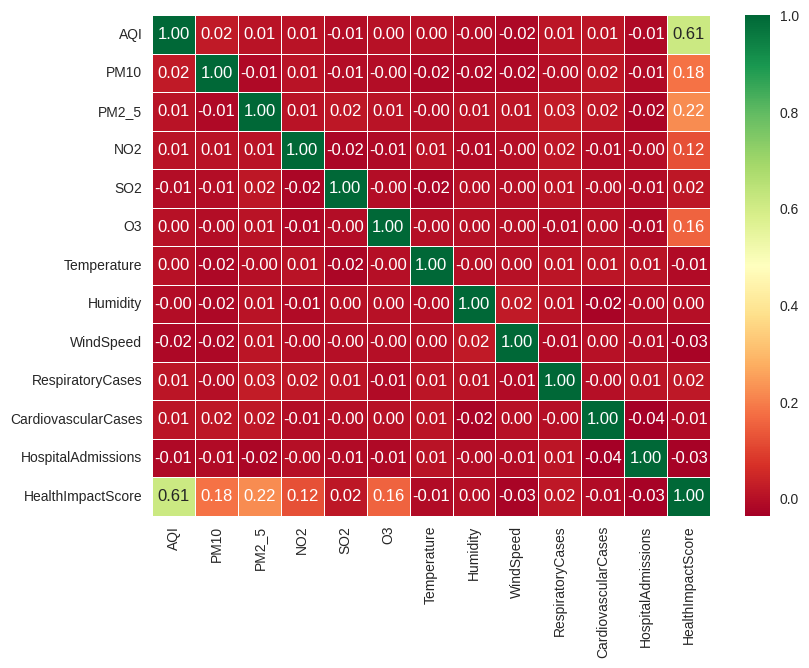

In [ ]:
# Correlation Heatmap
plt.figure(figsize=(9,6.5))
sns.heatmap(df.corr(),annot=True,linewidths=0.5,fmt='.2f',cmap="RdYlGn")

We can observe based on a correlation heatmap correlation between dependent variable (HealthImpactScore) and AQI. Also Moderate correlation to PM10, PM2_5, NO2 and O3. The rest of features shows weak correlation to dependent variable. There isn't visible high multicollinearity between features that could negatively impact models performance.

##Splitting

In [19]:
# Splitting set for train and test, with strattification that will ensure good data distribution
def stratify_splitting(df):
  split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

  # Define bin edges manually based on the value distribution
  bin_edges = [0, 25, 50, 75, 90, 100]
  df["HealthImpactScoreCat"] = pd.cut(df["HealthImpactScore"], bins=bin_edges, labels=[1, 2, 3, 4, 5], include_lowest=True)

  try:
    for train_index, test_index in split.split(df, df["HealthImpactScoreCat"]):
      strat_train_set = df.loc[train_index]
      strat_test_set = df.loc[test_index]
    feature_names = strat_train_set.drop(columns=["HealthImpactScore", "HealthImpactClass", "HealthImpactScoreCat"]).columns
    return strat_train_set, strat_test_set, feature_names
  except Exception as e:
    print(f"Error while splitting: {e}")
    return None

# Splitting data to X and y NumPy arays
def xy_splitting_scaling(strat_train_set, strat_test_set):
  try:
    X_train = strat_train_set.drop(columns=["HealthImpactScore", "HealthImpactClass", "HealthImpactScoreCat"])
    y_train = strat_train_set["HealthImpactScore"].values # Convert to NumPy array
    X_test = strat_test_set.drop(columns=["HealthImpactScore", "HealthImpactClass", "HealthImpactScoreCat"])
    y_test = strat_test_set["HealthImpactScore"].values
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    return X_train, y_train, X_test, y_test
  except Exception as e:
    print(f"Error while xy_splitting: {e}")

In [20]:
# Dataset load and splitting
file_path = 'https://raw.githubusercontent.com/Zanyata/Air_Quality/refs/heads/main/data/air_quality_health_impact_data.csv'
df = load_data(file_path)
strat_train_set, strat_test_set, feature_names = stratify_splitting(df)
X_train, y_train, X_test, y_test = xy_splitting_scaling(strat_train_set, strat_test_set)

##ML

###Manual MultiML

In [ ]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Polynomial Regression3": Pipeline([
        ('poly', PolynomialFeatures(degree=3)),
        ('lr', LinearRegression())]),
    "Random Forest": RandomForestRegressor(),
    "SVR": SVR(),
    "CatBoost": CatBoostRegressor(verbose=0),
    "LightGBM": LGBMRegressor(),
    "XGBoost": XGBRegressor()
}


In [ ]:
metrics = [mean_absolute_error, rmse, r2_score]

def evaluate_model(models, X_train, y_train, X_test, y_test):
    scores = []
    """Evaluate the model's performance on train and test sets."""
    plt.figure(figsize=(12,8))

    for i, (name, model) in enumerate(models.items()):
      # Train model
      model.fit(X_train, y_train)

      # Predictions
      preds = model.predict(X_test)

      model_scores = {"Model": name}
      for metric in metrics:
         model_scores[metric.__name__] = metric(y_test, preds)
      scores.append(model_scores)

      # Scatter plot for actual vs predicted values
      plt.subplot(4, 3, i + 1)  # Adjusting for more models
      plt.scatter(y_test, preds, alpha=0.5, edgecolors='k')
      plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
      plt.xlabel('Actual Values')
      plt.ylabel('Predicted Values')
      plt.title(f'{name}: Actual vs Predicted')

    plt.tight_layout()
    plt.show()

    # Convert results to DataFrame and display
    results_df = pd.DataFrame(scores)
    print("Model Evaluation Results:")
    print(results_df.to_string(index=False))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2344
[LightGBM] [Info] Number of data points in the train set: 4648, number of used features: 12
[LightGBM] [Info] Start training from score 93.755890


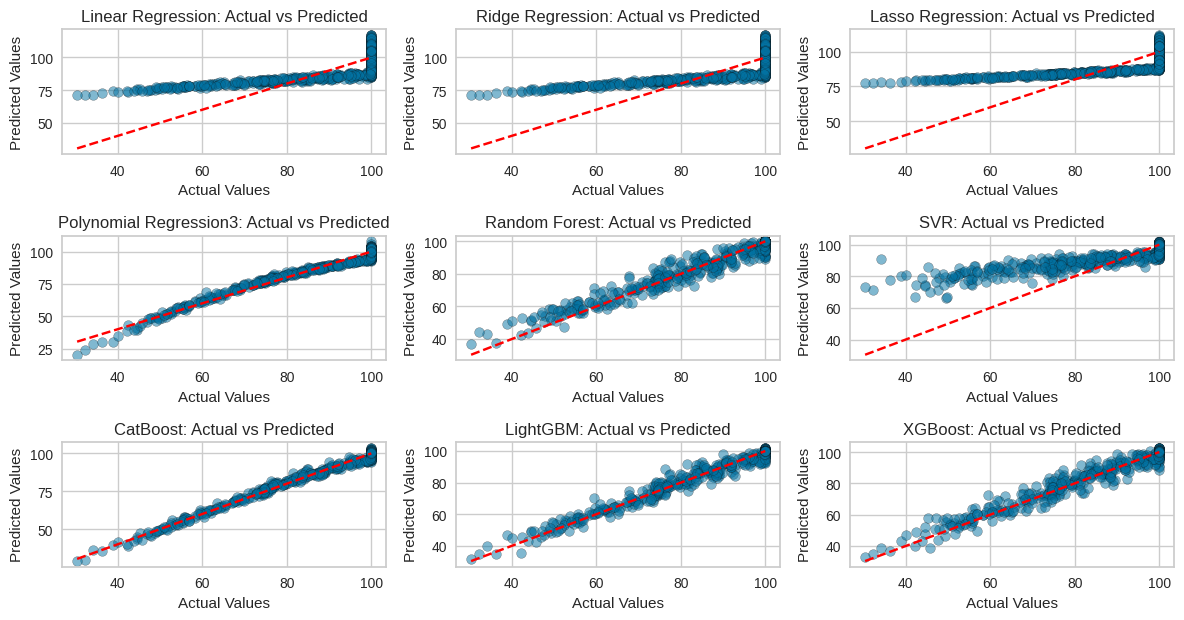

Model Evaluation Results:
                 Model  mean_absolute_error     rmse  r2_score
     Linear Regression             7.362296 9.442879  0.483767
      Ridge Regression             7.361822 9.442799  0.483776
      Lasso Regression             7.055804 9.630331  0.463068
Polynomial Regression3             1.671220 2.226435  0.971302
         Random Forest             1.247032 2.620878  0.960232
                   SVR             4.339640 8.348548  0.596486
              CatBoost             0.681326 1.196589  0.991711
              LightGBM             0.892913 1.849759  0.980191
               XGBoost             1.157334 2.337931  0.968355


In [ ]:
evaluate_model(models, X_train, y_train, X_test, y_test)

Best models CatBoost Regressor, LGBM Regressor, Polynomial Regression deg.3

Linear, Ridge, and Lasso Regression models showed significantly higher MAE and RMSE, indicating that they are not suitable for this dataset.

SVR showed moderate performance but lagged behind boosting methods.

###Hyperparameters tuning

In [21]:
# Model training, counting predictions and  training metrics
def model_tuning_reg(model, param_grid, model_name):

  folds = KFold(n_splits = 10, shuffle = True, random_state=42)
  metrics = [mean_absolute_error, rmse, r2_score]

  # GridSearchCV
  GS = GridSearchCV(
      estimator=model,
      param_grid=param_grid,
      scoring= 'neg_mean_squared_error', # focusing on penalizing larger errors more
      cv=folds,
      return_train_score=True,
      verbose=0,
      n_jobs=-1,  # Use all CPUs
      refit=True
  )

  # Training model
  GS.fit(X_train, y_train)
  best_model = GS.best_estimator_
  best_params = GS.best_params_
  preds_train= GS.predict(X_train)
  preds_test = GS.predict(X_test)

  # Training metrics
  scores = []
  for metric in metrics:
      scores.append(metric(y_train, preds_train))

  print("\n=== Training Metrics ===")
  print(f"Mean Absolute Error: {scores[0]:.4f}")
  print(f"RMSE: {scores[1]:.4f}")
  print(f"R2 Score: {scores[2]:.4f}")

  # Saving the best model
  filename = f"{model_name}.sav"
  pickle.dump(best_model, open(filename, "wb"))
  print(f"\nBest Parameters: {best_params}")
  return best_model, preds_test

In [22]:
# Test set evaluation and plotting confusion matrix
def evaluate_model_reg(preds, y_test):
    metrics = [mean_absolute_error, rmse, r2_score]
    scores = []
    """Evaluate the model's performance on train and test sets."""

    for metric in metrics:
        scores.append(metric(y_test, preds))

    print("\n=== Test Metrics ===")
    print(f"Mean Absolute Error: {scores[0]:.4f}")
    print(f"RMSE: {scores[1]:.4f}")
    print(f"R2 Score: {scores[2]:.4f}\n")

    # Scatter plot for actual vs predicted values
    plt.figure(figsize=(10,6))
    plt.scatter(y_test, preds, alpha=0.5, edgecolors='k')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title("Actual vs Predicted")
    plt.show()

###Polynomial Regression


=== Training Metrics ===
Mean Absolute Error: 1.5540
RMSE: 2.0815
R2 Score: 0.9757

Best Parameters: {'linreg__fit_intercept': True, 'poly__degree': 3, 'poly__include_bias': True, 'poly__interaction_only': False}
Search took 19.38 seconds.

=== Test Metrics ===
Mean Absolute Error: 1.6713
RMSE: 2.2264
R2 Score: 0.9713



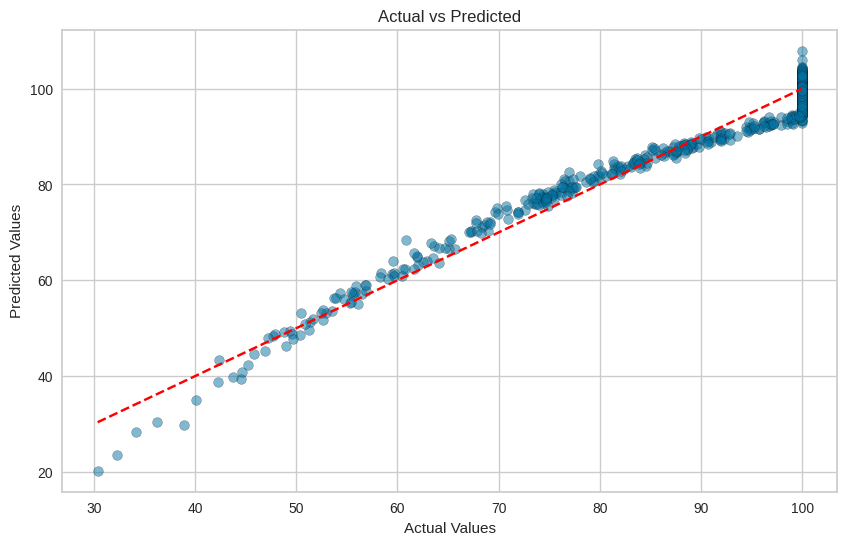

In [35]:
# Model instantiation
model = Pipeline([
    ('poly', PolynomialFeatures(degree=3)),  # Polynomial transformation (degree 3)
    ('linreg', LinearRegression())  # Linear Regression model
])

model_name = "reg_Poly"

# Time counter
start = time()

# Parameter Grid
param_grid = {
    'poly__interaction_only': [False, True],  # Include only interaction terms or full polynomial
    'poly__include_bias': [False, True],  # Whether to include a bias column
    'poly__degree': [2, 3, 4],  # Test polynomial degrees
    'linreg__fit_intercept': [True, False],  # Whether to calculate the intercept
}


Poly, preds_Poly  = model_tuning_reg(model, param_grid, model_name)
print(
    "Search took %.2f seconds."
    % ((time() - start))
)
evaluate_model_reg(preds_Poly, y_test)

###LGBM

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2344
[LightGBM] [Info] Number of data points in the train set: 4648, number of used features: 12
[LightGBM] [Info] Start training from score 93.755890

=== Training Metrics ===
Mean Absolute Error: 0.2327
RMSE: 0.4020
R2 Score: 0.9991

Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': -1, 'min_child_samples': 30, 'n_estimators': 500, 'num_leaves': 30, 'reg_alpha': 0.15, 'reg_lambda': 0.15, 'subsample': 0.6}
Search took 15689.51 seconds.

=== Test Metrics ===
Mean Absolute Error: 0.8463
RMSE: 1.6782
R2 Score: 0.9837



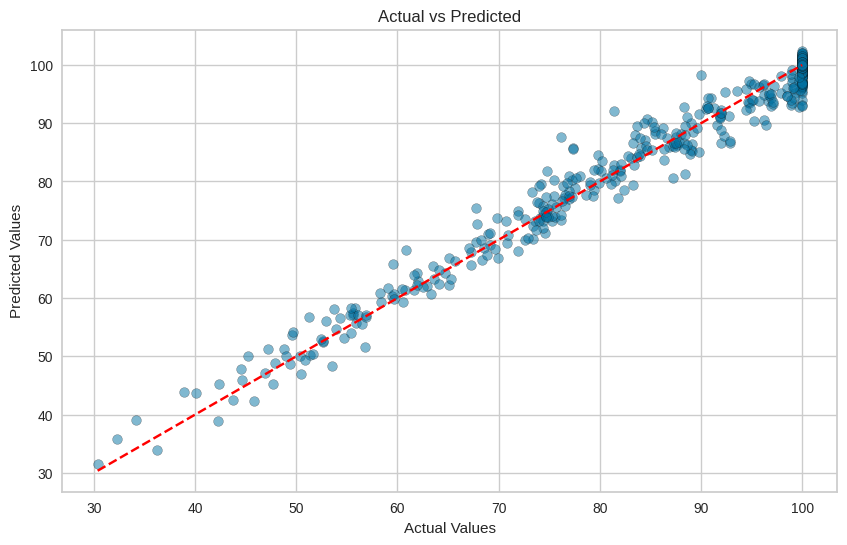

In [39]:
# Model instantiation
model = LGBMRegressor(random_state=42)

model_name = "reg_LGBM"

# TIme counter
start = time()

# Parameter Grid
param_grid = {
    'n_estimators': [500],  # Number of boosting rounds (trees)
    'learning_rate': [0.01, 0.05, 0.1],  # Step size shrinkage
    'max_depth': [-1, 20],  # Tree depth (-1 means no limit)
    'num_leaves': [30, 40],  # Maximum number of leaves per tree
    'min_child_samples': [30, 50],  # Minimum number of samples in a leaf
    'subsample': [0.6, 0.7, 0.8],  # Fraction of data used per iteration
    'colsample_bytree': [0.95, 1.0],  # Fraction of features used per iteration
    'reg_alpha': [0.05, 0.15, 0.1],  # L1 regularization
    'reg_lambda': [0.05, 0.1, 0.15]  # L2 regularization
}


LGBM_reg, preds_LGBM_reg  = model_tuning_reg(model, param_grid, model_name)
print(
    "Search took %.2f seconds."
    % ((time() - start))
)
evaluate_model_reg(preds_LGBM_reg, y_test)

###CatBoost Regressor


=== Training Metrics ===
Mean Absolute Error: 0.3190
RMSE: 0.5246
R2 Score: 0.9985

Best Parameters: {'depth': 8, 'iterations': 500, 'l2_leaf_reg': 3, 'learning_rate': 0.05, 'subsample': 0.9}
Search took 4550.03 seconds.

=== Test Metrics ===
Mean Absolute Error: 0.6394
RMSE: 1.1471
R2 Score: 0.9924



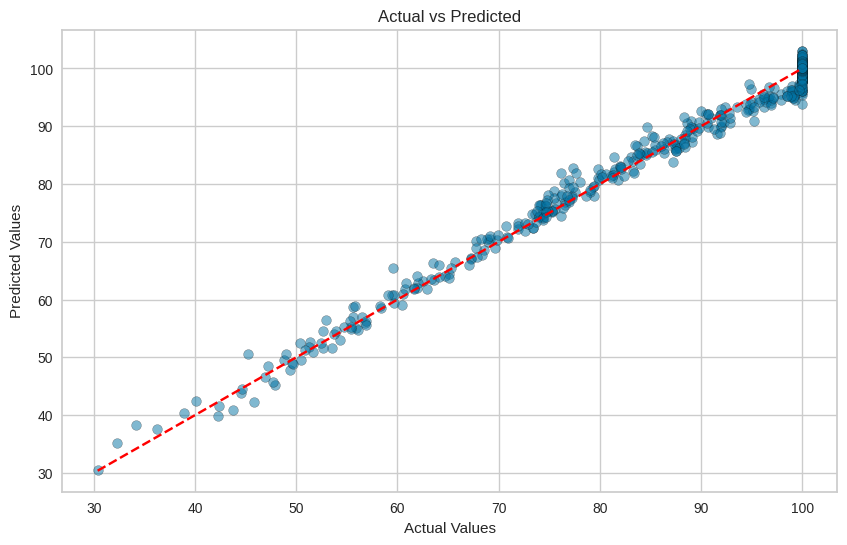

In [40]:
# Model instatiation
model = CatBoostRegressor(verbose=0, random_state=42, early_stopping_rounds=50)

model_name = "reg_CatBoost"

# Time counter
start = time()

# Parameter Grid
param_grid = {
    'iterations': [500],  # Number of boosting rounds
    'learning_rate': [0.05, 0.1, 0.15],  # Step size shrinkage
    'depth': [6, 8, 10],  # Maximum depth of the tree
    'l2_leaf_reg': [2, 3, 4],  # L2 regularization coefficient
    'subsample': [0.9, 1.0],  # Fraction of data used for training
}

Cat_reg, preds_Cat_reg  = model_tuning_reg(model, param_grid, model_name)
print(
    "Search took %.2f seconds."
    % ((time() - start))
)
evaluate_model_reg(preds_Cat_reg, y_test)

The key signs of overfitting are:

* Very high training accuracy / R² (almost perfect fit).
* Large performance gap between train and test metrics (train much better than test).

LGBM (R2 GAP 0.0154) and CatBoost Regressor (R2 GAP 0.0061) shows very slight signs of overfitting on training set - it's acceptable.

CatBoost as the Final Model:

* Given its superior metrics across all evaluation criteria, it is the
best candidate for deployment.

LightGBM as an Alternative:

* If CatBoost is computationally expensive, LightGBM offers a solid trade-off between speed and performance.

Polynomial Regression:

* While it performs well, it might overfit complex data.

#NN Classification

Given the issues with matching ML algorithm to this classification problem, it's a good idea to check performance of very simple NN model.

In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow import metrics

import warnings
warnings.filterwarnings('ignore')

In [23]:
# Splitting X_train, y_train for additional validation set needed for NN
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

In [24]:
# Sequential API
# Model definition
model = tf.keras.Sequential([
    tf.keras.layers.Dense(36, input_shape=(12,), activation="relu"),
    tf.keras.layers.Dense(36, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(36, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=len(np.unique(y_train)), activation="softmax"),
])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 36)                  │             468 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 36)                  │           1,332 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 36)                  │             144 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 36)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 36)                  │           1,332 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 36)                  │             144 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             148 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,568 (13.94 KB)

 Trainable params: 3,424 (13.38 KB)

 Non-trainable params: 144 (576.00 B)

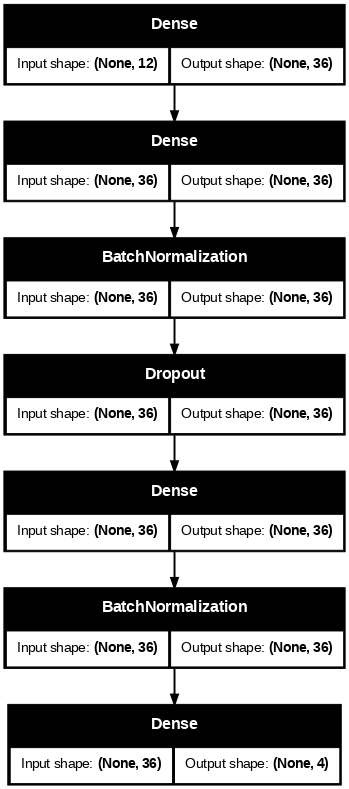

In [25]:
model.summary()
schema = tf.keras.utils.plot_model(model, show_shapes=True, dpi=70)
schema

In [26]:
# Compiling Model
model.compile(optimizer="adam", metrics=['accuracy'], loss="sparse_categorical_crossentropy")

# Early Stopping definition
early_stopping = EarlyStopping(
    monitor="val_loss", # For an imbalanced classification problem, val_loss is generally
                        # better for early stopping to use val_loss than val_accuracy
    verbose=1,
    patience=15,
    restore_best_weights=True
)

# Model training
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=100,
    callbacks=[early_stopping]
    )


# Get predictions on TRAINING set
preds_train_proba = model.predict(X_train)  # Predict probabilities
preds_train = np.argmax(preds_train_proba, axis=1)  # Convert probabilities to class labels

# Get predictions on TEST set
preds_test_proba = model.predict(X_test)  # Predict probabilities
preds_test = np.argmax(preds_test_proba, axis=1)  # Convert probabilities to class labels


model.evaluate(X_test, y_test)

model.save("my_model.h5")



Epoch 1/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.3488 - loss: 2.2251 - val_accuracy: 0.8688 - val_loss: 1.2832
Epoch 2/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7850 - loss: 1.2995 - val_accuracy: 0.8742 - val_loss: 0.8350
Epoch 3/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8889 - loss: 0.8454 - val_accuracy: 0.8731 - val_loss: 0.6706
Epoch 4/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8962 - loss: 0.6717 - val_accuracy: 0.8914 - val_loss: 0.5366
Epoch 5/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9131 - loss: 0.5386 - val_accuracy: 0.9323 - val_loss: 0.4424
Epoch 6/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9089 - loss: 0.4879 - val_accuracy: 0.9172 - val_loss: 0.3949
Epoch 7/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9171 - loss: 0.4163 - val_accuracy: 0.9387 - val_loss: 0.3275
Epoch 8/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9258 - loss: 0.3657 - val_accu


=== Classification Report train===
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3199
         1.0       0.96      1.00      0.98       353
         2.0       0.97      0.99      0.98       141
         3.0       0.95      0.84      0.89        25

    accuracy                           0.99      3718
   macro avg       0.97      0.96      0.96      3718
weighted avg       0.99      0.99      0.99      3718


=== Evaluation Metrics train===
Precision: 0.9553598088055004
Recall: 0.9551172880925352
F1 Score: 0.9553598088055
Accuracy: 0.9601626353845301
ROC-AUC Score: 0.9983902309420056

=== Classification Report test===
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99      1001
         1.0       0.83      0.95      0.89       110
         2.0       0.89      0.93      0.91        44
         3.0       0.89      1.00      0.94         8

    accuracy                           0.98

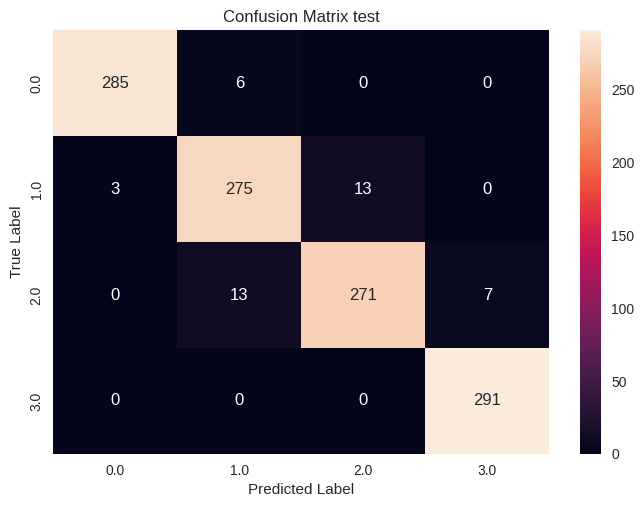

In [27]:
# Evaluation function
def evaluate(preds, preds_proba, y, status):
    metrics = [precision_score, recall_score, f1_score]
    scores = []
    sample_weights = compute_sample_weight(class_weight="balanced", y=y)
    for metric in metrics:
        scores.append(metric(y, preds, sample_weight=sample_weights, average='weighted', zero_division=0))

    # Compute ROC-AUC score
    accuracy = accuracy_score(y, preds, sample_weight=sample_weights)
    scores.append(accuracy)
    roc_auc = roc_auc_score(y, preds_proba, sample_weight=sample_weights, multi_class="ovr", average="weighted")
    scores.append(roc_auc)

    # Print classification report
    print(f"\n=== Classification Report {status}===")
    print(classification_report(y, preds))

    # Confusion Matrix
    conf_matrix = confusion_matrix(y, preds, sample_weight=sample_weights)

    print(f"\n=== Evaluation Metrics {status}===")
    print('Precision: '+str(scores[1]))
    print('Recall: '+str(scores[2]))
    print('F1 Score: '+str(scores[3]))
    print('Accuracy: '+str(scores[0]))
    print('ROC-AUC Score: '+str(scores[4]))

    return conf_matrix

# Function to plot evaluation results
def plot_evaluation(conf_matrix, status):


    # Plot confusion matrix with heatmap
    sns.heatmap(conf_matrix,
                  annot=True,
                  fmt=".0f",
                  xticklabels=np.unique(y_test),
                  yticklabels=np.unique(y_test))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix {status}')
    plt.show()

conf_matrix_train = evaluate(preds_train, preds_train_proba, y_train, "train")
conf_matrix_test = evaluate(preds_test, preds_test_proba, y_test, "test")
plot_evaluation(conf_matrix_test, "test")

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])



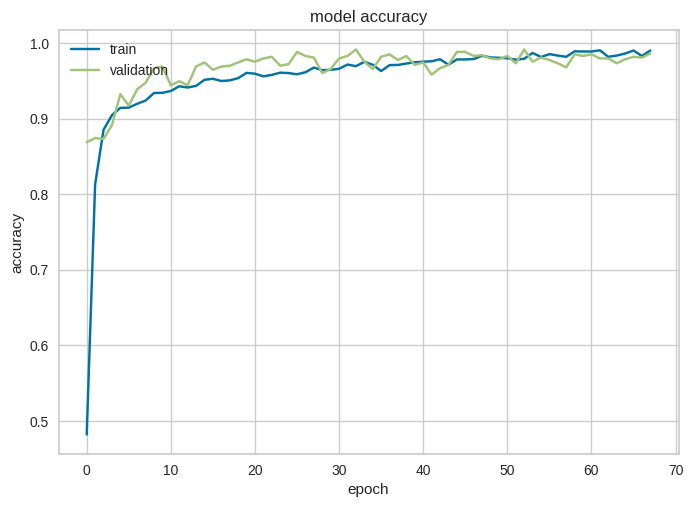

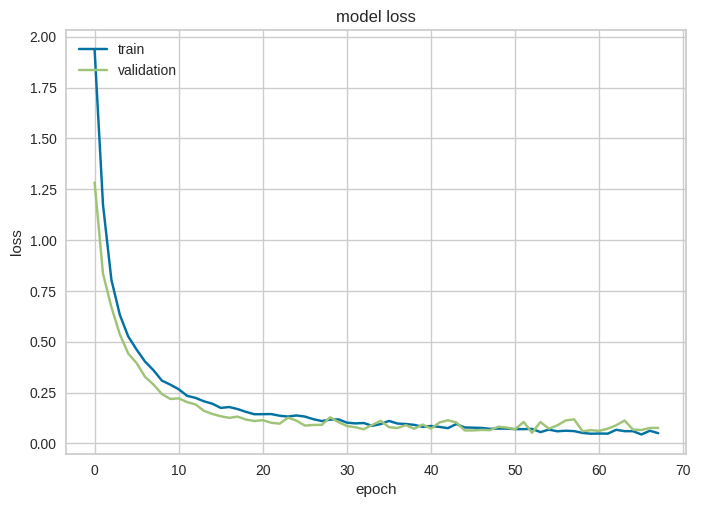

In [28]:
# Plotting models accuracy and lost during training
df = pd.DataFrame(history.history)

# list all data in history
print(history.history.keys())
print()
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Simple NN model, 4 layers (2 hidden layers) performs better than best ML Classifiers. Logistic Regression has the similar performance, but using more complex algorithm might be more advisable. NN is the best solution for this classification task and doesn't show signs of overfitting.